# Análisis Ley de Torricelli

Ubicamos las partículas más altas y más a la derecha para determinar la altura del fluido y las primeras partículas que salen por el agujero del lado derecho.

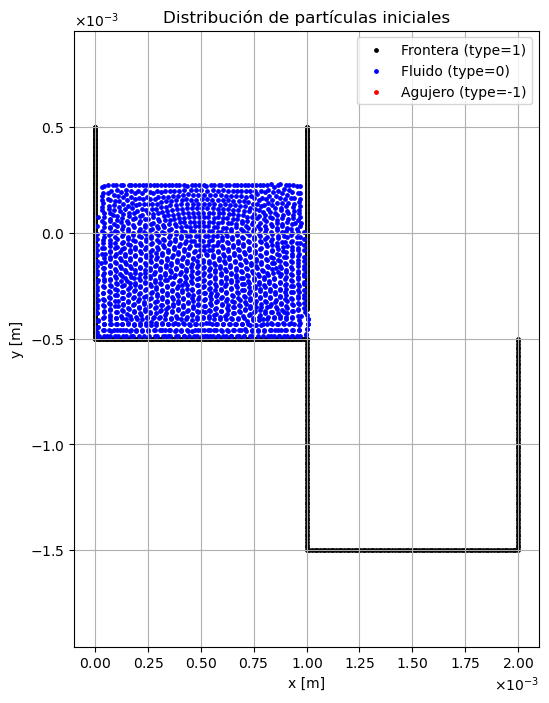

In [9]:
import sys
from pathlib import Path

PROJECT_ROOT = Path().resolve().parent
sys.path.append(str(PROJECT_ROOT))

from Config.utils.plot_ics import plot_ics

step10fall  = PROJECT_ROOT / "Output" / "vaciado_caida4k" / "Output" / "state_0010.txt"

plot_ics(step10fall)

Usaremos el paso 10 para que halla el tiempo suficiente en que algunas pocas partículas pasen el agujero

In [10]:
import numpy as np

file = str(step10fall)   # Cambiar por el archivo que quieras

data = np.loadtxt(file, skiprows=1)

# Columnas según tu formato
ids   = data[:,0]
posx  = data[:,1]
posy  = data[:,2]
types = data[:,12]

# Filtrar solo las partículas de interés: type = 0
mask = types == 0

ids_0  = ids[mask]
posx_0 = posx[mask]
posy_0 = posy[mask]

# Partícula más alta
i_max_y = np.argmax(posy_0)
id_max_y = ids_0[i_max_y]
height   = posy_0[i_max_y]

# Partícula más a la derecha
i_max_x  = np.argmax(posx_0)
id_max_x = ids_0[i_max_x]
rightmost = posx_0[i_max_x]

print(f"Partícula más alta: id={id_max_y}, altura={height}")
print(f"Partícula más a la derecha: id={id_max_x}, posx={rightmost}")


Partícula más alta: id=2387.0, altura=0.0002296475
Partícula más a la derecha: id=1028.0, posx=0.0010064304


In [11]:
from utils.upRightPos import find_part_up_right

file = step10fall
n_up = 15
n_right = 5

up_part, right_part = find_part_up_right(file, n_up, n_right)

print("Altas:", up_part)
print("Más a la derecha:", right_part)

Altas: {2387: 0.0002296475, 2388: 0.0002288241, 2371: 0.0002285679, 2389: 0.0002285123, 2348: 0.000228485, 2349: 0.0002281488, 2367: 0.000227828, 2386: 0.0002278003, 2357: 0.0002271995, 2372: 0.0002271828, 2381: 0.0002271598, 2369: 0.0002269887, 2383: 0.0002269839, 2368: 0.0002269162, 2382: 0.000226796}
Más a la derecha: {1028: 0.0010064304, 989: 0.0010061842, 949: 0.0010050429, 988: 0.0010050291, 909: 0.0010036757}


Promedio de altura de fluido y de partículas más a la derecha

In [12]:
import numpy as np

up_mean = np.mean(list(up_part.values()))
right_mean = np.mean(list(right_part.values()))

print("Promedio de alturas:", up_mean)
print("Promedio de posiciones derechas:", right_mean)


Promedio de alturas: 0.00022780272
Promedio de posiciones derechas: 0.0010052724599999999


In [13]:
h = up_mean
g = 9.8

torri_law = np.sqrt(2*g*h)
print(torri_law)

0.06682015647991256


In [14]:
import numpy as np
import glob
import re
from pathlib import Path

def track_particle(folder, particle_id):
    """
    Lee todos los archivos state_*.txt dentro de 'folder'
    y rastrea la posición y velocidad de una partícula dada por su id.
    """

    folder = Path(folder)

    # Buscar archivos que coincidan con state_*.txt
    files = list(folder.glob("state_*.txt"))

    # Ordenar por el número dentro del nombre state_XXXX.txt
    def extract_num(fname):
        match = re.search(r"state_(\d+)\.txt", fname.name)
        return int(match.group(1)) if match else -1

    files = sorted(files, key=extract_num)

    # Listas donde se acumula la trayectoria
    times = []
    posx_list = []
    posy_list = []
    velx_list = []
    vely_list = []

    for f in files:
        step = extract_num(f)
        
        # Cargar archivo (saltando encabezado)
        data = np.loadtxt(f, skiprows=1)

        ids   = data[:,0]
        posx  = data[:,1]
        posy  = data[:,2]
        velx  = data[:,3]
        vely  = data[:,4]

        # Buscar índice donde id == particle_id
        match = np.where(ids == particle_id)[0]

        if len(match) == 0:
            print(f"⚠ Advertencia: Partícula {particle_id} no aparece en {f.name}")
            continue

        idx = match[0]

        times.append(step)
        posx_list.append(posx[idx])
        posy_list.append(posy[idx])
        velx_list.append(velx[idx])
        vely_list.append(vely[idx])

    return {
        "time_steps": np.array(times),
        "posx": np.array(posx_list),
        "posy": np.array(posy_list),
        "velx": np.array(velx_list),
        "vely": np.array(vely_list),
    }

In [15]:
# Rastrear la partícula
folder = PROJECT_ROOT / "Output" / "vaciado_caida4k" / "Output"
particle_id = 1028     # cámbiala por la partícula que quieras seguir

traj_1028 = track_particle(folder, particle_id)

In [16]:
import matplotlib.pyplot as plt
# Se debe multiplicar el valor de tiempo por el dt para pasar a segundos

dt = 5e-5

t_1028 = traj_1028["time_steps"] * dt
x_1028 = traj_1028["posx"]
y_1028 = traj_1028["posy"]

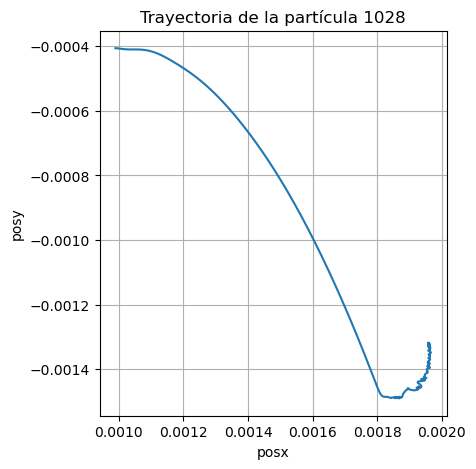

In [17]:
import matplotlib.pyplot as plt

# --- Gráfico de la trayectoria en 2D ---
plt.figure(figsize=(6,5))
plt.plot(x_1028, y_1028)
plt.xlabel("posx")
plt.ylabel("posy")
plt.title(f"Trayectoria de la partícula {particle_id}")
plt.grid(True)
plt.gca().set_aspect('equal', adjustable='box')
plt.show()

Es necesario determinar el lugar en el que la partícula rebota en el fondo del nuevo recipiente

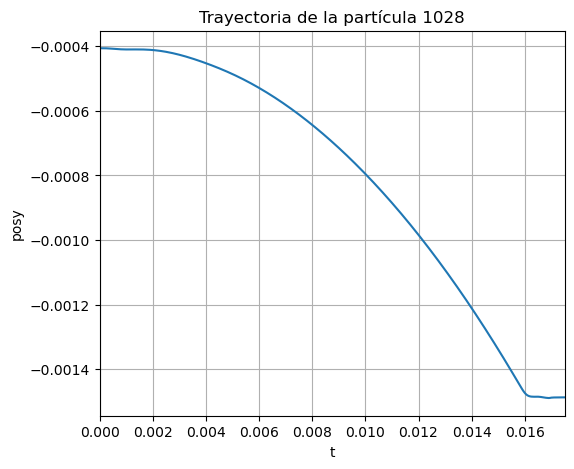

In [18]:
import matplotlib.pyplot as plt

# --- Gráfico de la trayectoria en 2D ---
plt.figure(figsize=(6,5))
plt.plot(t_1028, y_1028)
plt.xlabel("t")
plt.ylabel("posy")
plt.title(f"Trayectoria de la partícula {particle_id}")
plt.xlim(0, 0.0175)
plt.grid(True)
#plt.gca().set_aspect('equal', adjustable='box')
plt.show()

La caída de la partícula 1028 parece darse hasta cerca de un tiempo de 0.016s, calculamos el paso en el que esto ocurrre:

In [19]:
fall_step = 0.016 / 5e-5
print("Paso aproximado en la que la primera partícula rebota:", fall_step)

Paso aproximado en la que la primera partícula rebota: 320.0


In [20]:
import numpy as np

# Extraer vectores
steps = np.asarray(traj_1028["time_steps"])
x = np.asarray(traj_1028["posx"])
y = np.asarray(traj_1028["posy"])

x_par = [x[i] for i in range(int(fall_step))]
y_par = [y[i] for i in range(int(fall_step))]
t_par = [steps[i]*dt for i in range(int(fall_step))]

In [21]:
# Ajustamos a un polinomio de grado 2: y = at^2 + bt + c

coef = np.polyfit(t_par, y_par, 2)

a, b, c = coef
g = 2*a
print(a,b,c)
print("Aceleración gravitacional:", g)

-4.679279662003979 0.008338964227895283 -0.0004106178594747342
Aceleración gravitacional: -9.358559324007958


In [22]:
traj_1028.items()

dict_items([('time_steps', array([    0,     1,     2, ..., 11997, 11998, 11999])), ('posx', array([0.0009895 , 0.00099014, 0.00099116, ..., 0.00196159, 0.00196159,
       0.00196159])), ('posy', array([-0.0004062 , -0.00040619, -0.00040621, ..., -0.0013344 ,
       -0.0013344 , -0.00133441])), ('velx', array([8.92610160e-03, 1.69138104e-02, 2.37169472e-02, ...,
       4.07260000e-06, 4.07880000e-06, 4.07000000e-06])), ('vely', array([ 1.745266e-04,  1.790670e-05, -5.000661e-04, ..., -6.404450e-05,
       -6.419620e-05, -6.431180e-05]))])

In [23]:
print("El valor de la velocidad inicial según Torricelli es", torri_law)

El valor de la velocidad inicial según Torricelli es 0.06682015647991256


Para ver si en la simulación concuerda hacemos uso de graficar la velocidad en x vs. el tiempo, la velocidad debe hacerse constante en algún punto ya que no hay aceleración en x.

In [24]:
vel_x1028 = traj_1028["velx"]
print(vel_x1028)

[8.92610160e-03 1.69138104e-02 2.37169472e-02 ... 4.07260000e-06
 4.07880000e-06 4.07000000e-06]


(0.0, 0.02)

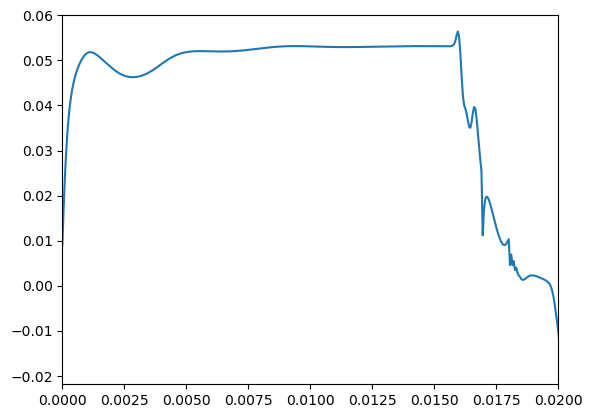

In [25]:
plt.plot(t_1028, vel_x1028)
plt.xlim(0,400*dt)

Vemos que el valor luego de la interacción con frontera se estabiliza alrededor de 0.05 m/s, mientras que según la ley de Torricelli esta debería estar alrededor de 0.07 m/s.

In [26]:
# Velocidad inicial en y calculada con el ajuste

print("Velocidad inicial en y ajuste:", b)

Velocidad inicial en y ajuste: 0.008338964227895283


In [2]:
import numpy as np

h = 0.00022780272
g=9.35

torri_law2 = np.sqrt(2*g*h)

print(torri_law2)

0.06526799264570651
